In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
import os
import cv2
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchsummary import summary
from itertools import cycle
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

zip_file_path = '/content/drive/My Drive/imagenette2-320.zip'
extraction_path = '/content/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

Mounted at /content/drive


In [ ]:
# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is available!
GPU Name: NVIDIA L4


## Pre-processing: transforms, val/test split, dataloaders

In [ ]:
# Paths to the train and val directories
train_dir = '/content/drive/MyDrive/dataset/imagenette2-320/train'
val_dir = '/content/drive/MyDrive/dataset/imagenette2-320/val'

# Define transformations
transform_resize = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image to 256x256
    transforms.ToTensor(),          # Convert the image to a tensor
])

# Load train and val datasets with transformations
train_dataset = ImageFolder(root=train_dir, transform=transform_resize)
full_val_dataset = ImageFolder(root=val_dir, transform=transform_resize)

# Split the validation data into validation and test datasets
val_size = int(0.5 * len(full_val_dataset))
test_size = len(full_val_dataset) - val_size
val_dataset, test_dataset = random_split(full_val_dataset, [val_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Print number of images in each dataset and shape of an image
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")
print(f"Shape of a training image: {train_dataset[0][0].shape}")
print(f"Shape of a validation image: {val_dataset[0][0].shape}")
print(f"Shape of a test image: {test_dataset[0][0].shape}")

# Class Labels
classes = ['Tench', 'English Springer', 'Cassette Player', 'Chainsaw', 'Church', 'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute']
print(classes)

Number of training images: 9469
Number of validation images: 1962
Number of test images: 1963
Shape of a training image: torch.Size([3, 256, 256])
Shape of a validation image: torch.Size([3, 256, 256])
Shape of a test image: torch.Size([3, 256, 256])
['Tench', 'English Springer', 'Cassette Player', 'Chainsaw', 'Church', 'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute']


## Training Function: with validation early stopping

In [ ]:
def train_model(model, train_dataloader, val_dataloader, num_epochs, optimizer, loss_function, val_patience=3):
    train_loss, val_loss = [], [] # initializing loss lists
    train_acc, val_acc = [], []  # initializing accuracy lists
    previous_val_loss = float('inf')
    val_patience = val_patience
    val_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_running_loss, train_running_correct = 0.0, 0

        progress_bar_train = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch")
        for data in progress_bar_train:
            inputs, targets = data
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad() # zeroing the parameters

            outputs = model(inputs) # forward pass through the model

            loss = loss_function(outputs, targets) # calculating the loss
            train_running_loss += loss.item() * inputs.size(0)
            # multiplying the loss by the number of samples in the batch, thereby weighting its loss value
            # this is because the last batch may have fewer samples

            loss.backward() # backpropogation
            optimizer.step()

           # determining accurate predictions
            _, preds = torch.max(outputs, 1)
            train_running_correct += torch.sum(preds == targets.data)

        # calculating/appending epoch loss and accuracy
        epoch_loss = train_running_loss / len(train_dataloader.dataset) # dividing by the total number of samples
        epoch_acc = train_running_correct.double() / len(train_dataloader.dataset)
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc.item())

        model.eval()
        val_running_loss, val_running_correct = 0.0, 0

        with torch.no_grad():
            progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", unit="batch")
            for val_data in progress_bar_val:
                inputs, targets = val_data
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs) # forward pass
                loss = loss_function(outputs, targets) # loss calculation
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_running_correct += torch.sum(preds == targets.data) # determining accurate predictions

        # calculating/appending epoch loss and accuracy
        val_epoch_loss = val_running_loss / len(val_dataloader.dataset)
        val_epoch_acc = val_running_correct.double() / len(val_dataloader.dataset)
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc.item())

        print(f'Epoch {epoch+1:2d} | Train Loss: {epoch_loss:.4f}, Train Acc: {(epoch_acc)*100:.2f} | Val Loss: {val_epoch_loss:.4f}, Val Acc: {(val_epoch_acc)*100:.2f}')

        # Early stopping
        if val_loss[-1] > previous_val_loss:
            val_counter += 1
            if val_counter >= val_patience:
                print('Early stopping condition met. Validation loss is increasing.')
                break
        else:
            previous_val_loss = val_loss[-1]
            val_counter = 0

    return train_loss, train_acc, val_loss, val_acc

## Plotting Function: training and validation metrics

In [ ]:
def plot_metrics(train_losses, train_accuracies, val_losses, val_accuracies, model_type):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training loss')
    plt.plot(epochs, val_losses, 'b', label='Validation loss')
    plt.title(f'{model_type} - Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation accuracy')
    plt.title(f'{model_type} - Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

## Test Evaluation Function

In [ ]:
def evaluate_model(model, test_dataloader, loss_function):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        with tqdm(test_dataloader, desc='Testing', unit='batch') as test_data:
            for inputs, targets in test_data:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = loss_function(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == targets.data)

                all_predictions.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

    test_loss = running_loss / len(test_dataloader.dataset)
    test_acc = running_corrects.double() / len(test_dataloader.dataset)

    print('\n')
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%")
    print('\n')

    cm = confusion_matrix(all_targets, all_predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Test Set Confusion Matrix')
    plt.show()

    report_metrics = classification_report(all_targets, all_predictions)
    print('\n')
    print(report_metrics)

    return test_loss, test_acc


## VGG-16

In [2]:
class VGG16Base(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16Base, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Adjusted fully connected layers for 256x256 input
        self.linear_layers = nn.Sequential(
            nn.Linear(512 * 8 * 8, 4096),  # 8x8 comes from (256 / 2^5 = 8)
            nn.ReLU(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)
        x = self.linear_layers(x)
        return x

Epoch 1/50 - Validation: 100%|██████████| 62/62 [05:59<00:00,  5.79s/batch]


Epoch  1 | Train Loss: 1.5699, Train Acc: 45.08 | Val Loss: 1.2222, Val Acc: 59.99


Epoch 2/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.27batch/s]


Epoch  2 | Train Loss: 1.0057, Train Acc: 67.28 | Val Loss: 1.1587, Val Acc: 62.74


Epoch 3/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.25batch/s]


Epoch  3 | Train Loss: 0.7811, Train Acc: 74.77 | Val Loss: 0.9312, Val Acc: 69.52


Epoch 4/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.26batch/s]


Epoch  4 | Train Loss: 0.6336, Train Acc: 79.36 | Val Loss: 0.8394, Val Acc: 73.04


Epoch 5/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.26batch/s]


Epoch  5 | Train Loss: 0.5333, Train Acc: 82.62 | Val Loss: 1.0102, Val Acc: 70.85


Epoch 6/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.25batch/s]


Epoch  6 | Train Loss: 0.4407, Train Acc: 85.54 | Val Loss: 0.7698, Val Acc: 75.89


Epoch 7/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.27batch/s]


Epoch  7 | Train Loss: 0.3512, Train Acc: 88.28 | Val Loss: 0.7517, Val Acc: 77.68


Epoch 8/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.27batch/s]


Epoch  8 | Train Loss: 0.2759, Train Acc: 90.93 | Val Loss: 0.7221, Val Acc: 79.36


Epoch 9/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.28batch/s]


Epoch  9 | Train Loss: 0.2004, Train Acc: 93.57 | Val Loss: 0.8830, Val Acc: 76.40


Epoch 10/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.26batch/s]


Epoch 10 | Train Loss: 0.1581, Train Acc: 94.58 | Val Loss: 0.7222, Val Acc: 80.94


Epoch 11/50 - Validation: 100%|██████████| 62/62 [00:08<00:00,  7.25batch/s]


Epoch 11 | Train Loss: 0.1152, Train Acc: 96.31 | Val Loss: 0.7995, Val Acc: 79.97
Early stopping condition met. Validation loss is increasing.


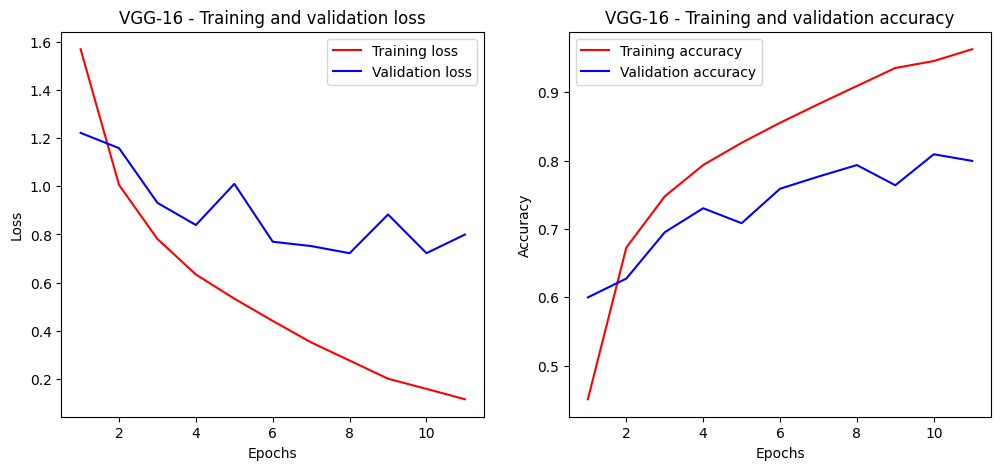

In [ ]:
model = VGG16Base(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)
plot_metrics(train_loss, train_acc, val_loss, val_acc, 'VGG-16')

Testing: 100%|██████████| 62/62 [05:58<00:00,  5.78s/batch]




Test Loss: 0.7834, Test Accuracy: 79.72%




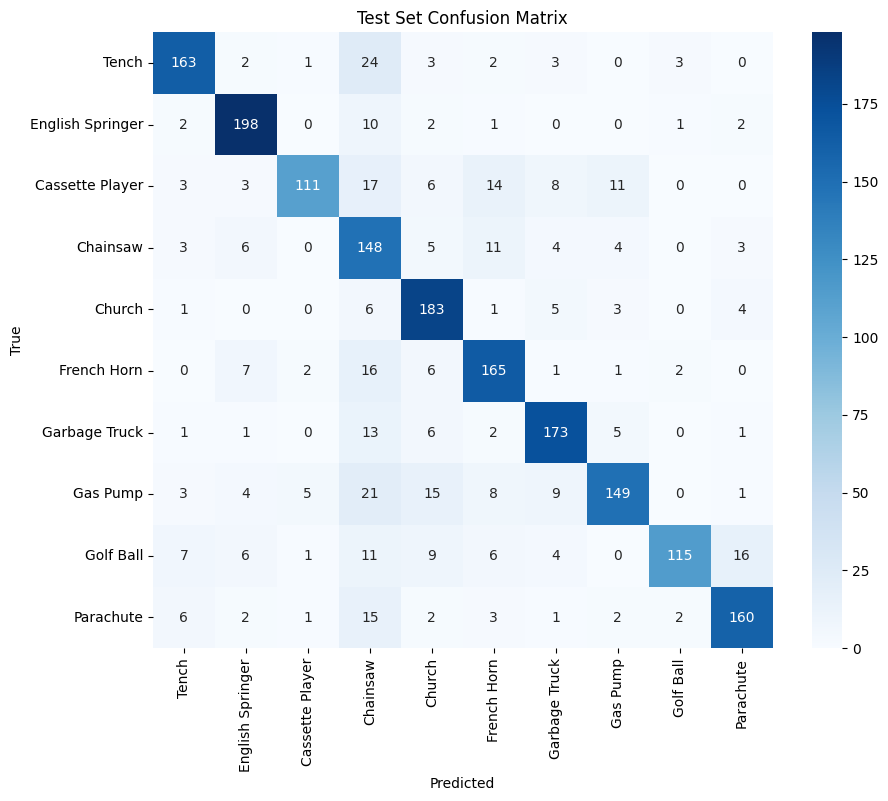



              precision    recall  f1-score   support

           0       0.86      0.81      0.84       201
           1       0.86      0.92      0.89       216
           2       0.92      0.64      0.76       173
           3       0.53      0.80      0.64       184
           4       0.77      0.90      0.83       203
           5       0.77      0.82      0.80       200
           6       0.83      0.86      0.84       202
           7       0.85      0.69      0.76       215
           8       0.93      0.66      0.77       175
           9       0.86      0.82      0.84       194

    accuracy                           0.80      1963
   macro avg       0.82      0.79      0.80      1963
weighted avg       0.82      0.80      0.80      1963



In [ ]:
vgg_test_loss, vgg_test_acc = evaluate_model(model, test_loader, criterion)

In [ ]:
vgg_model = model
torch.save(vgg_model, '/content/drive/MyDrive/vgg_model.pth')

In [ ]:
# Load the model
# model = torch.load('/content/drive/MyDrive/vgg_model.pth')

VGG16Base(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), pa

## ResNet-34

In [ ]:
class ResidualBlock(nn.Module):

    def __init__(self, inchannels, outchannels, stride = 1):
        super(ResidualBlock, self).__init__()
        self.stride = stride
        self.conv1 = nn.Conv2d(in_channels = inchannels, out_channels = outchannels, kernel_size = 3,
                               stride = stride, padding = 1)
        self.norm1 = nn.BatchNorm2d(outchannels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels = outchannels, out_channels = outchannels, kernel_size = 3,
                               stride = 1, padding = 1)
        self.norm2 = nn.BatchNorm2d(outchannels)

        self.downsize = nn.Conv2d(in_channels = inchannels, out_channels = outchannels, kernel_size = 1, stride = 2)

    def forward(self, x):

        identity = x

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.norm2(x)

        if self.stride == 2:
            identity = self.downsize(identity)

        x += identity
        x = self.relu(x)

        return x

class ResNet34(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(ResNet34, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 64, kernel_size = 7, stride = 2, padding = 3)
        self.norm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = nn.Sequential(
            ResidualBlock(inchannels = 64, outchannels = 64, stride = 1),
            ResidualBlock(inchannels = 64, outchannels = 64),
            ResidualBlock(inchannels = 64, outchannels = 64))

        self.layer2 = nn.Sequential(
            ResidualBlock(inchannels = 64, outchannels = 128, stride = 2),
            ResidualBlock(inchannels = 128, outchannels = 128),
            ResidualBlock(inchannels = 128, outchannels = 128),
            ResidualBlock(inchannels = 128, outchannels = 128))

        self.layer3 = nn.Sequential(
            ResidualBlock(inchannels = 128, outchannels = 256, stride = 2),
            ResidualBlock(inchannels = 256, outchannels = 256),
            ResidualBlock(inchannels = 256, outchannels = 256),
            ResidualBlock(inchannels = 256, outchannels = 256),
            ResidualBlock(inchannels = 256, outchannels = 256),
            ResidualBlock(inchannels = 256, outchannels = 256))

        self.layer4 = nn.Sequential(
            ResidualBlock(inchannels = 256, outchannels = 512, stride = 2),
            ResidualBlock(inchannels = 512, outchannels = 512),
            ResidualBlock(inchannels = 512, outchannels = 512))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

Epoch 1/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.53batch/s]


Epoch  1 | Train Loss: 1.6801, Train Acc: 42.44 | Val Loss: 1.6920, Val Acc: 47.20


Epoch 2/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.91batch/s]


Epoch  2 | Train Loss: 1.1955, Train Acc: 60.15 | Val Loss: 1.6541, Val Acc: 48.47


Epoch 3/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.16batch/s]


Epoch  3 | Train Loss: 0.9506, Train Acc: 69.11 | Val Loss: 1.1420, Val Acc: 64.27


Epoch 4/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.84batch/s]


Epoch  4 | Train Loss: 0.7844, Train Acc: 74.22 | Val Loss: 1.0434, Val Acc: 67.84


Epoch 5/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.02batch/s]


Epoch  5 | Train Loss: 0.6539, Train Acc: 78.48 | Val Loss: 1.4598, Val Acc: 57.70


Epoch 6/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.96batch/s]


Epoch  6 | Train Loss: 0.5325, Train Acc: 82.51 | Val Loss: 0.9683, Val Acc: 70.80


Epoch 7/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.68batch/s]


Epoch  7 | Train Loss: 0.4150, Train Acc: 86.10 | Val Loss: 1.3674, Val Acc: 60.96


Epoch 8/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.83batch/s]


Epoch  8 | Train Loss: 0.3201, Train Acc: 89.61 | Val Loss: 1.0144, Val Acc: 70.08


Epoch 9/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.90batch/s]


Epoch  9 | Train Loss: 0.2343, Train Acc: 92.36 | Val Loss: 0.9816, Val Acc: 72.32
Early stopping condition met. Validation loss is increasing.


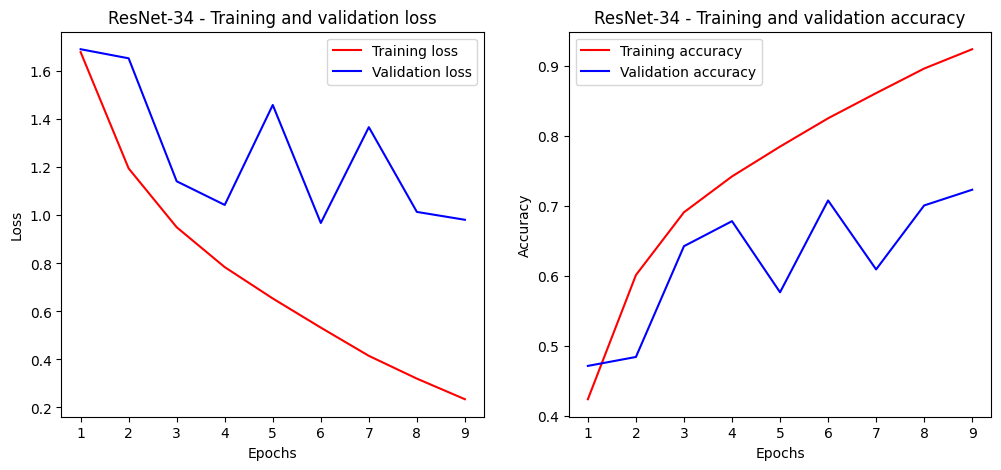

In [ ]:
model = ResNet34(in_channels = 3, num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)
plot_metrics(train_loss, train_acc, val_loss, val_acc, 'ResNet-34')

In [ ]:
resnet_model = model
torch.save(resnet_model, '/content/drive/MyDrive/resnet_model.pth')

Testing: 100%|██████████| 62/62 [00:05<00:00, 10.38batch/s]




Test Loss: 1.0765, Test Accuracy: 69.69%




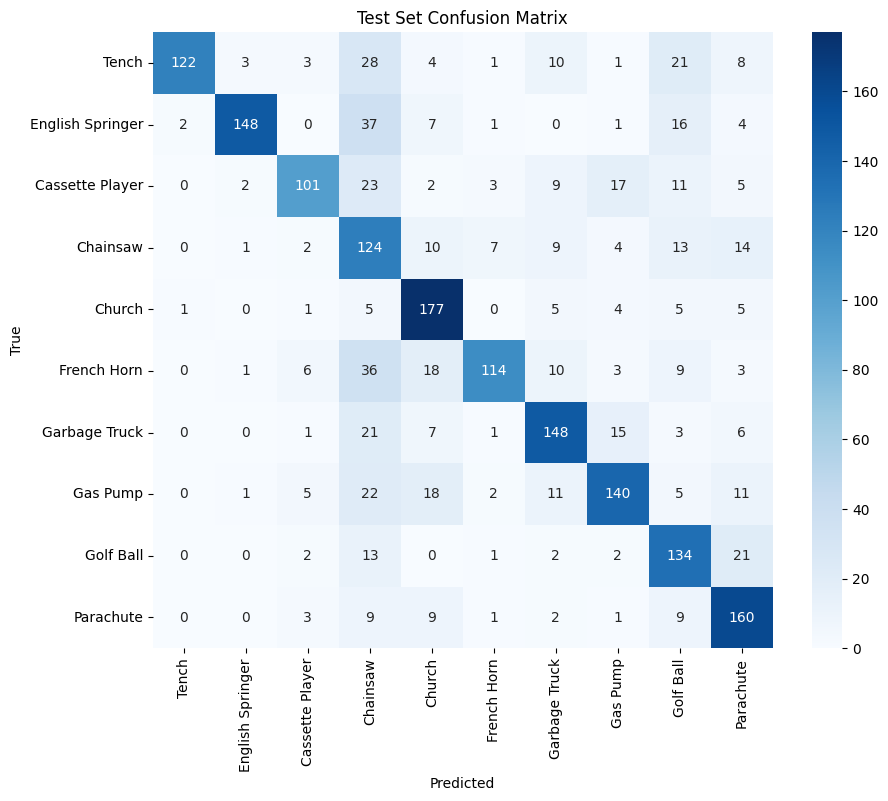



              precision    recall  f1-score   support

           0       0.98      0.61      0.75       201
           1       0.95      0.69      0.80       216
           2       0.81      0.58      0.68       173
           3       0.39      0.67      0.49       184
           4       0.70      0.87      0.78       203
           5       0.87      0.57      0.69       200
           6       0.72      0.73      0.73       202
           7       0.74      0.65      0.69       215
           8       0.59      0.77      0.67       175
           9       0.68      0.82      0.74       194

    accuracy                           0.70      1963
   macro avg       0.74      0.70      0.70      1963
weighted avg       0.75      0.70      0.70      1963



In [ ]:
resnet_test_loss, resnet_test_acc = evaluate_model(model, test_loader, criterion)

## MobileNet

In [ ]:
class dwconv(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(dwconv, self).__init__()
        self.dwlayer = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=stride, padding=1, groups=in_channels, bias=False)
        self.pwlayer = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)


    def forward(self, x):
        x = self.dwlayer(x)
        x = self.pwlayer(x)
        x = self.norm(x)
        return self.relu(x)


class mobilenet(nn.Module):
    def __init__(self, num_classes=10):
        super(mobilenet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            dwconv(32, 64, stride=1),
            dwconv(64, 128, stride=2),
            dwconv(128, 128, stride=1),
            dwconv(128, 256, stride=2),
            dwconv(256, 256, stride=1),
            dwconv(256, 512, stride=2),
            dwconv(512, 512, stride=1),
            dwconv(512, 512, stride=1),
            dwconv(512, 512, stride=1),
            dwconv(512, 512, stride=1),
            dwconv(512, 512, stride=1),
            dwconv(512, 1024, stride=2),
            dwconv(1024, 1024, stride=1),
            nn.AdaptiveAvgPool2d(1)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )


    def forward(self, x):
        x = self.model(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

Epoch 1/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.34batch/s]


Epoch  1 | Train Loss: 2.0923, Train Acc: 24.73 | Val Loss: 2.1806, Val Acc: 24.62


Epoch 2/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.79batch/s]


Epoch  2 | Train Loss: 1.7693, Train Acc: 36.70 | Val Loss: 1.9695, Val Acc: 38.02


Epoch 3/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.93batch/s]


Epoch  3 | Train Loss: 1.5266, Train Acc: 46.41 | Val Loss: 1.9271, Val Acc: 41.23


Epoch 4/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.13batch/s]


Epoch  4 | Train Loss: 1.3715, Train Acc: 53.16 | Val Loss: 1.6140, Val Acc: 50.00


Epoch 5/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.14batch/s]


Epoch  5 | Train Loss: 1.2414, Train Acc: 58.35 | Val Loss: 1.2481, Val Acc: 58.82


Epoch 6/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.89batch/s]


Epoch  6 | Train Loss: 1.1243, Train Acc: 63.35 | Val Loss: 1.0896, Val Acc: 64.32


Epoch 7/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.62batch/s]


Epoch  7 | Train Loss: 1.0456, Train Acc: 65.76 | Val Loss: 1.0139, Val Acc: 66.62


Epoch 8/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.88batch/s]


Epoch  8 | Train Loss: 0.9495, Train Acc: 68.89 | Val Loss: 0.9742, Val Acc: 69.06


Epoch 9/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.57batch/s]


Epoch  9 | Train Loss: 0.8569, Train Acc: 71.74 | Val Loss: 1.0181, Val Acc: 68.65


Epoch 10/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.99batch/s]


Epoch 10 | Train Loss: 0.7685, Train Acc: 74.74 | Val Loss: 0.8873, Val Acc: 71.87


Epoch 11/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.21batch/s]


Epoch 11 | Train Loss: 0.6942, Train Acc: 77.54 | Val Loss: 0.9653, Val Acc: 69.78


Epoch 12/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.78batch/s]


Epoch 12 | Train Loss: 0.6422, Train Acc: 79.06 | Val Loss: 1.0793, Val Acc: 68.96


Epoch 13/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.15batch/s]


Epoch 13 | Train Loss: 0.5812, Train Acc: 81.12 | Val Loss: 0.9454, Val Acc: 70.54
Early stopping condition met. Validation loss is increasing.


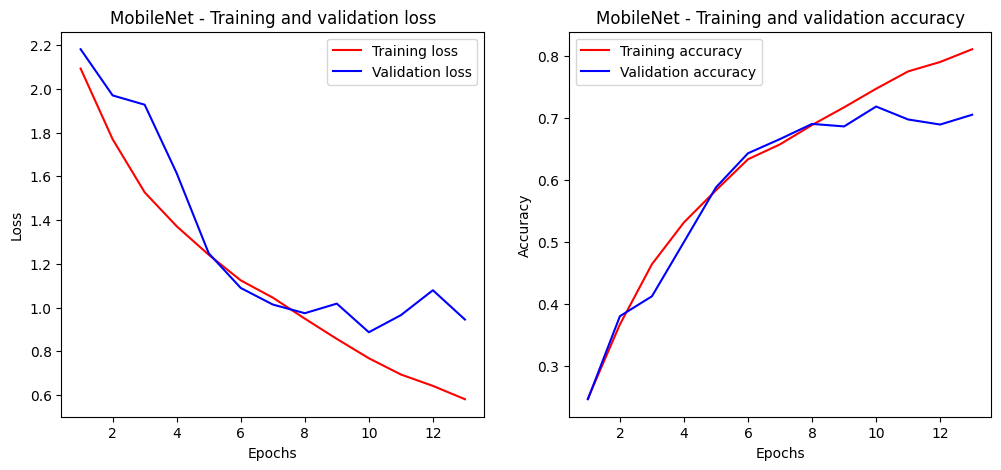

In [ ]:
model = mobilenet(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)
plot_metrics(train_loss, train_acc, val_loss, val_acc, 'MobileNet')

In [ ]:
mobilenet_model = model
torch.save(mobilenet_model, '/content/drive/MyDrive/mobilenet_model.pth')

Testing: 100%|██████████| 62/62 [00:06<00:00,  9.86batch/s]




Test Loss: 0.9865, Test Accuracy: 68.67%




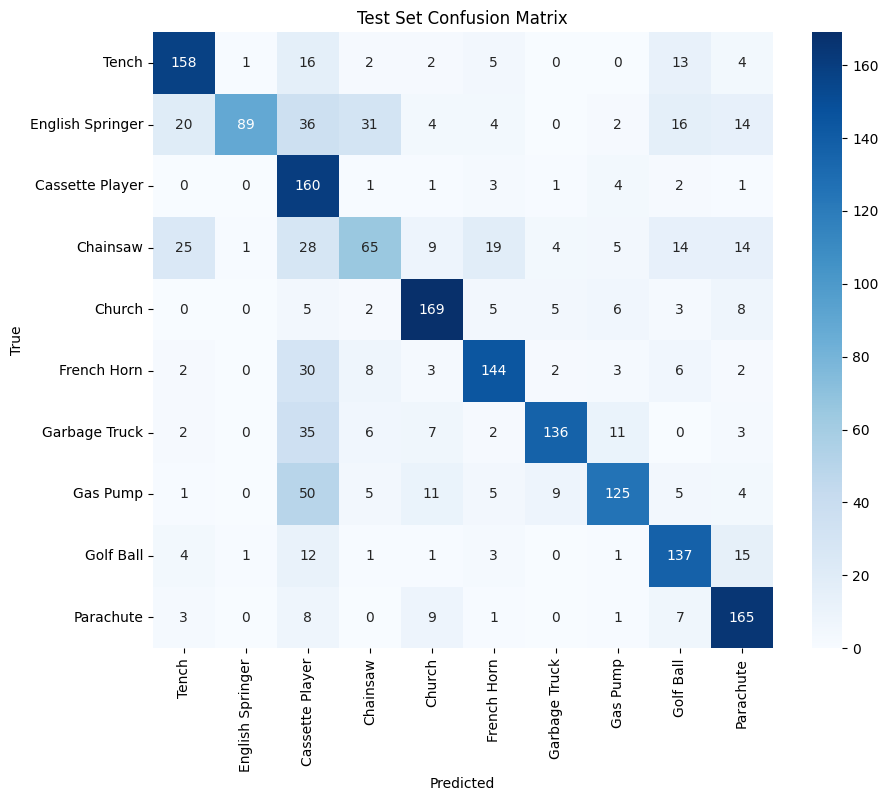



              precision    recall  f1-score   support

           0       0.73      0.79      0.76       201
           1       0.97      0.41      0.58       216
           2       0.42      0.92      0.58       173
           3       0.54      0.35      0.43       184
           4       0.78      0.83      0.81       203
           5       0.75      0.72      0.74       200
           6       0.87      0.67      0.76       202
           7       0.79      0.58      0.67       215
           8       0.67      0.78      0.72       175
           9       0.72      0.85      0.78       194

    accuracy                           0.69      1963
   macro avg       0.72      0.69      0.68      1963
weighted avg       0.73      0.69      0.68      1963



In [ ]:
mobilenet_test_loss, mobilenet_test_acc = evaluate_model(model, test_loader, criterion)

## DenseNet-121

In [ ]:
# Transition layer: used to resize the input/output as it's being passed from one dense block to another.
class transition(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()

        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = 1, bias = False)
        self.avgpool = nn.AvgPool2d(kernel_size = 2, stride = 2)

    def forward(self, x):

        x = self.norm(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.avgpool(x)

        return x

# Dense layer
class denselayer(nn.Module):
    def __init__(self, in_channels, growth_rate, bn_size, dropout) -> None:
        super().__init__()

        # used in the bottleneck
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, bn_size*growth_rate, kernel_size = 1, stride = 1, bias = False)

        # used in the forward pass
        self.norm2 = nn.BatchNorm2d(bn_size*growth_rate)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(bn_size*growth_rate, growth_rate, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.droprate = float(dropout)

    # def bottleneck(self, x): #-> Tensor:
        # the inputted x will be a list of tensors, therefore we will concatenate them into 1 tensor.
        # x = torch.cat(x, 1)
        # x = self.norm1(x)
        # x = self.relu1(x)
        # x = self.conv1(x)

        # return x

    def forward(self, x) -> torch.Tensor:

        out = self.norm1(x)
        out = self.relu1(out)
        out = self.conv1(out)

        out = self.norm2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.droprate > 0:
            out = F.dropout(out, p = self.droprate) # training=self.training ?

        out = torch.cat([x, out], 1)
        return out

# Dense block
class denseblock(nn.Module):
    def __init__(self, n_layers, in_channels, growth_rate, bn_size, dropout):
        super().__init__()

        layers = []
        for i in range(n_layers):
            layers.append(denselayer(in_channels = in_channels + i*growth_rate, growth_rate = growth_rate, bn_size = bn_size, dropout = dropout))
        self.dense_block = nn.Sequential(*layers)

    def forward(self, x):
        return self.dense_block(x)

# DenseNet
class DenseNet121(nn.Module):
    def __init__(self, block_config, growth_rate, n_classes, initial_channels=3, bn_size=4, dropout=0):
        super().__init__()
        # block config is a list of the number of layers for each denseblock: [6, 12, 24, 16] for DenseNet-121
        # n_classes is the final number of classfication categories you want to develop predictions for.
        # growth_rate is the number of feature layers that will be concatenated to the output of every layer

        initial_output = 64 # number of output channels for the first convolutional layer... typically 64
        self.conv1 = nn.Conv2d(initial_channels, initial_output, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.norm1 = nn.BatchNorm2d(initial_output)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        output_layers = initial_output
        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()

        for i, n_layers in enumerate(block_config):
            block = denseblock(n_layers = n_layers, in_channels = output_layers, growth_rate = growth_rate, bn_size = bn_size, dropout = dropout)
            self.dense_blocks.append(block)
            output_layers += n_layers*growth_rate
            if i != len(block_config) - 1:
                transit = transition(in_channels = output_layers, out_channels = output_layers//2)
                self.transition_layers.append(transit)
                output_layers = output_layers//2

        self.norm2 = nn.BatchNorm2d(output_layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(output_layers, n_classes)

    def forward(self, x) -> torch.Tensor:

        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for i in range(len(self.dense_blocks)):
            x = self.dense_blocks[i](x)
            if i != len(self.dense_blocks) - 1:
                x = self.transition_layers[i](x)

        x = self.norm2(x)
        x = self.relu(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

Epoch 1/50 - Training:   0%|          | 0/296 [00:00<?, ?batch/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.66batch/s]


Epoch  1 | Train Loss: 2.0484, Train Acc: 30.66 | Val Loss: 1.8665, Val Acc: 40.32


Epoch 2/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.02batch/s]


Epoch  2 | Train Loss: 1.7497, Train Acc: 43.56 | Val Loss: 1.7952, Val Acc: 41.08


Epoch 3/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.95batch/s]


Epoch  3 | Train Loss: 1.5463, Train Acc: 50.22 | Val Loss: 1.5084, Val Acc: 47.45


Epoch 4/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.09batch/s]


Epoch  4 | Train Loss: 1.3993, Train Acc: 54.99 | Val Loss: 2.7981, Val Acc: 29.92


Epoch 5/50 - Validation: 100%|██████████| 62/62 [00:05<00:00, 10.36batch/s]


Epoch  5 | Train Loss: 1.3044, Train Acc: 58.19 | Val Loss: 2.0083, Val Acc: 40.77


Epoch 6/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.06batch/s]


Epoch  6 | Train Loss: 1.1704, Train Acc: 62.89 | Val Loss: 1.1384, Val Acc: 63.51


Epoch 7/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.08batch/s]


Epoch  7 | Train Loss: 1.0693, Train Acc: 65.58 | Val Loss: 1.2876, Val Acc: 57.29


Epoch 8/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.85batch/s]


Epoch  8 | Train Loss: 1.0029, Train Acc: 68.02 | Val Loss: 1.0916, Val Acc: 65.65


Epoch 9/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.87batch/s]


Epoch  9 | Train Loss: 0.9255, Train Acc: 70.40 | Val Loss: 1.6870, Val Acc: 47.09


Epoch 10/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.84batch/s]


Epoch 10 | Train Loss: 0.8875, Train Acc: 71.26 | Val Loss: 0.9056, Val Acc: 71.87


Epoch 11/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.97batch/s]


Epoch 11 | Train Loss: 0.8394, Train Acc: 72.75 | Val Loss: 0.8548, Val Acc: 73.24


Epoch 12/50 - Validation: 100%|██████████| 62/62 [00:05<00:00, 10.35batch/s]


Epoch 12 | Train Loss: 0.8043, Train Acc: 74.40 | Val Loss: 0.8676, Val Acc: 73.55


Epoch 13/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.86batch/s]


Epoch 13 | Train Loss: 0.7555, Train Acc: 75.50 | Val Loss: 1.4676, Val Acc: 57.08


Epoch 14/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.03batch/s]


Epoch 14 | Train Loss: 0.7078, Train Acc: 77.88 | Val Loss: 0.7959, Val Acc: 74.46


Epoch 15/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.08batch/s]


Epoch 15 | Train Loss: 0.6829, Train Acc: 77.85 | Val Loss: 0.8312, Val Acc: 74.11


Epoch 16/50 - Validation: 100%|██████████| 62/62 [00:06<00:00, 10.06batch/s]


Epoch 16 | Train Loss: 0.6561, Train Acc: 78.88 | Val Loss: 0.9091, Val Acc: 70.85


Epoch 17/50 - Validation: 100%|██████████| 62/62 [00:06<00:00,  9.98batch/s]


Epoch 17 | Train Loss: 0.6341, Train Acc: 79.67 | Val Loss: 0.9285, Val Acc: 70.18
Early stopping condition met. Validation loss is increasing.


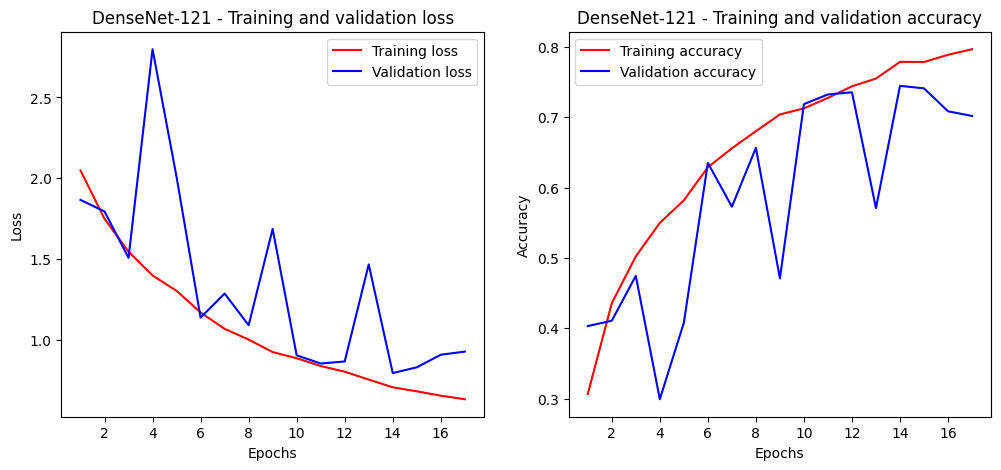

In [ ]:
model = DenseNet121(block_config = [6, 12, 24, 16], growth_rate = 4, n_classes = 10).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.0001)
num_epochs = 50

train_loss, train_acc, val_loss, val_acc = train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion)
plot_metrics(train_loss, train_acc, val_loss, val_acc, 'DenseNet-121')

In [ ]:
dense_model = model
torch.save(mobilenet_model, '/content/drive/MyDrive/densenet_model.pth')

Testing: 100%|██████████| 62/62 [00:06<00:00,  9.91batch/s]




Test Loss: 0.9772, Test Accuracy: 68.52%




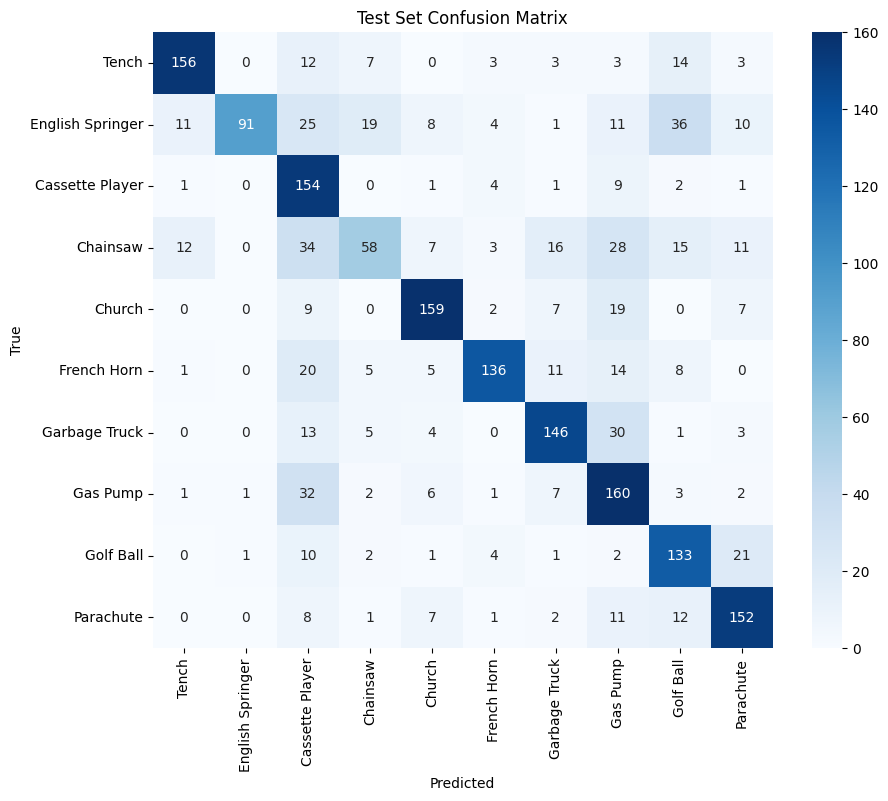



              precision    recall  f1-score   support

           0       0.86      0.78      0.81       201
           1       0.98      0.42      0.59       216
           2       0.49      0.89      0.63       173
           3       0.59      0.32      0.41       184
           4       0.80      0.78      0.79       203
           5       0.86      0.68      0.76       200
           6       0.75      0.72      0.74       202
           7       0.56      0.74      0.64       215
           8       0.59      0.76      0.67       175
           9       0.72      0.78      0.75       194

    accuracy                           0.69      1963
   macro avg       0.72      0.69      0.68      1963
weighted avg       0.73      0.69      0.68      1963



In [ ]:
densenet_test_loss, densenet_test_acc = evaluate_model(model, test_loader, criterion)

## Performance comparison on test set

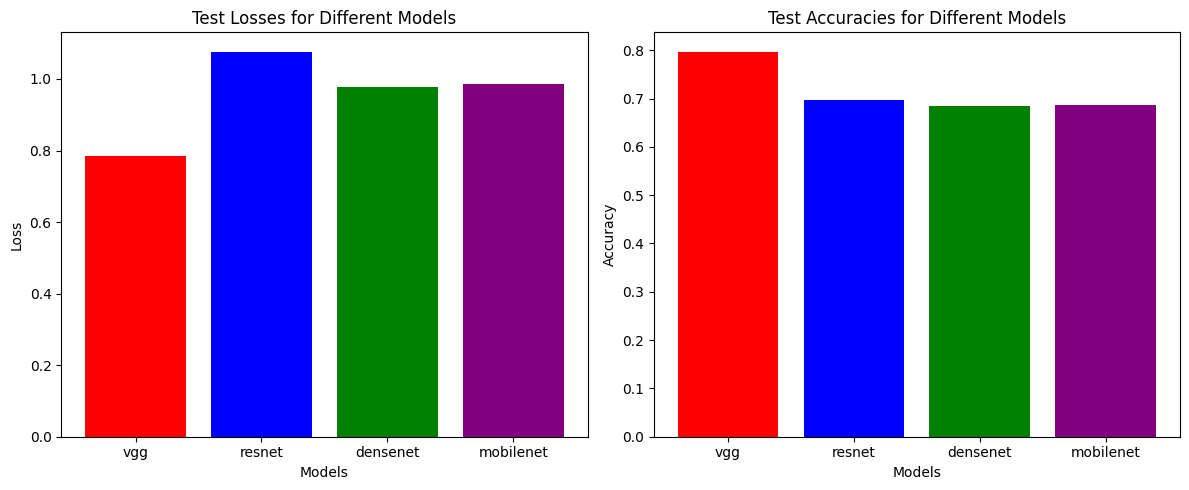

In [ ]:
import matplotlib.pyplot as plt

model_metrics = {
    'vgg': {'loss': vgg_test_loss, 'accuracy': vgg_test_acc.item()},
    'resnet': {'loss': resnet_test_loss, 'accuracy': resnet_test_acc.item()},
    'densenet': {'loss': densenet_test_loss, 'accuracy': densenet_test_acc.item()},
    'mobilenet': {'loss': mobilenet_test_loss, 'accuracy': mobilenet_test_acc.item()}
}

models = list(model_metrics.keys())
test_losses = [model_metrics[model]['loss'] for model in models]
test_accuracies = [model_metrics[model]['accuracy'] for model in models]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models, test_losses, color=['red', 'blue', 'green', 'purple'])
plt.title('Test Losses for Different Models')
plt.xlabel('Models')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.bar(models, test_accuracies, color=['red', 'blue', 'green', 'purple'])
plt.title('Test Accuracies for Different Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()
